# Experiment 10: PCA Comparisons (V-velocity)

In this experiment we will use two datasets:

First dataset: 
- (Available) Training data: 11 months 
- Testing data: 1 month

Second dataset:
- (Available) Training data: 6 months 
- Testing data: 6 months

Using these datasets we will look at the reconstruction error of the PCA models with 100 components, but fitted using different temporal periods.



### Imports:

In [1]:
%matplotlib notebook

In [2]:
# Import packages:
import mikeio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import sys
import pandas as pd 
import pickle as pkl


sys.path.append("../")
plt.style.use("seaborn-v0_8-whitegrid")

from Scripts import my_functions as mf

from mikeio.eum import EUMUnit
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from IPython.display import HTML
from tqdm import tqdm

### Data Extraction

In [3]:
## Find the relative path to Data/DHI_wk_sim/Area.dfsu from current directory:

# Go up two levels from current directory:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# Overwrite path:
path = os.path.join(path, "Data/DHI_yr_sim/Area.dfsu")

# Get first and last time step:
time = mikeio.open(path).time

# Load data (2 min):
data = mikeio.read(path,
                   time=slice("1997-01-01 00:00:00",
                              "1998-01-01 00:00:00"),
                   items="V velocity")

In [4]:
data

<mikeio.Dataset>
dims: (time:17519, element:17980)
time: 1997-01-01 00:00:00 - 1997-12-31 23:00:00 (17519 records)
geometry: Dfsu2D (17980 elements, 10460 nodes)
items:
  0:  V velocity <v velocity component> (meter per sec)

### Models:

In [5]:
# Super class for models:
class myModels():
    
    def __init__(self):
        pass
    
    # Templates:
    class ModelTemplate:
        """
        Ensures that the methods fit, predict, and fit_predict are 
        instantiated for all classes based on this template.
        """

        def fit(self, X, y=None):
            raise NotImplementedError("fit method must be implemented in subclass")

        def predict(self, X):
            raise NotImplementedError("predict method must be implemented in subclass")

        def fit_predict(self, X, y=None):
            self.fit(X, y)
            return self.predict(X)
        
    class IPCA(ModelTemplate):

        def __init__(self, n_components=None):
            self.n_components = n_components
            self.model = IncrementalPCA(n_components=self.n_components,
                                        batch_size=self.n_components)

        def fit(self, X, y=None):
            self.model.fit(X, y)
            return self

        def predict(self, X):
            X = self.model.transform(X)
            return self.model.inverse_transform(X)
        
    class PCA(ModelTemplate):
        
        def __init__(self, n_components=None):
            self.n_components = n_components
            self.model = PCA(n_components=self.n_components)

        def fit(self, X, y=None):
            self.model.fit(X, y)
            return self

        def predict(self, X):
            X = self.model.transform(X)
            return self.model.inverse_transform(X)

## Data split: (11 months training data. 1 month test data.)

In [6]:
# Split data into training and test sets:
v_train = data.V_velocity.sel(time=slice("1997-01-01 00:00:00",
                                         "1997-12-01 00:00:00")).values

v_test = data.V_velocity.sel(time=slice("1997-12-01 00:00:00",
                                        "1998-01-01 00:00:00")).values

### Samples:

In [7]:
# First week, week-sized random sample, and week-sized systematic sample:
wk_1 = range(0, 48*7); np.random.seed(42)
wk_random = np.random.choice(range(0, v_train.shape[0]), 48*7, replace=False)
wk_system = np.linspace(0, v_train.shape[0]-1, 48*7, dtype=int)

# First month, month-sized random sample, and month-sized systematic sample:
mth_1 = range(0, 48*7*4)
mth_random = np.random.choice(range(0, v_train.shape[0]), 48*7*4, replace=False)
mth_system = np.linspace(0, v_train.shape[0]-1, 48*7*4, dtype=int)

# First three months, three-month-sized random sample, and three-month-sized systematic sample:
mth_3 = range(0, 48*7*4*3)
mth_3_random = np.random.choice(range(0, v_train.shape[0]), 48*7*4*3, replace=False)
mth_3_system = np.linspace(0, v_train.shape[0]-1, 48*7*4*3, dtype=int)

In [8]:
# Sample indices:
sample_ids = [wk_1, wk_random, wk_system,
              mth_1, mth_random, mth_system,
              mth_3, mth_3_random, mth_3_system]


### Results

In [9]:
# Auxilliary variable:
compute = 1

# Try to load results from earlier runs:
if 1:

    # Load scalers and pcas if they exist:
    if os.path.exists("../Data_Results/Exp_10_scalers.pkl") and \
        os.path.exists("../Data_Results/Exp_10_pcas.pkl"):
        
        # Load scalers:
        with open("../Data_Results/Exp_10_scalers.pkl", "rb") as f:
            scalers = pkl.load(f)

        # Load pcas:
        with open("../Data_Results/Exp_10_pcas.pkl", "rb") as f:
            pcas = pkl.load(f)

        # Change compute to 0:
        compute = 0

print(f"compute = {compute}")

compute = 0


In [10]:
# Compute scalers and pcas (+5 min):
if compute:

    # Lists for scalers and pcas:
    scalers = [];  pcas = []

    for i in range(len(sample_ids)):
        
        print(f"Sample {i+1} of {len(sample_ids)}", end="\r")

        # Pick data:
        v_data = v_train[sample_ids[i]]

        # Create scaler:
        scaler = StandardScaler()

        # Fit scaler:
        scaler.fit(v_data)

        # Scale data:
        v_data_scaled = scaler.transform(v_data)

        # Create pca:
        pca = myModels.IPCA(n_components=100)

        # Fit pca:
        pca.fit(v_data_scaled)

        # Append scalers and pcas:
        scalers.append(scaler)
        pcas.append(pca)

In [11]:
# Save scalers and pcas (in Coding/Data_Results):
if compute:
    with open("../Data_Results/Exp_10_scalers.pkl", "wb") as f:
        pkl.dump(scalers, f)

    with open("../Data_Results/Exp_10_pcas.pkl", "wb") as f:
        pkl.dump(pcas, f)

In [12]:
def reconstruct(data, scaler, pca, batch_size=1000):
    """
    Reconstructs data using scaler and pca.
    """

    if data.shape[0] < batch_size:
        data_scaled = scaler.transform(data)
        data_scaled_recon = pca.predict(data_scaled)
        data_recon = scaler.inverse_transform(data_scaled_recon)

    else:
        data_recon = np.zeros(data.shape)
        for i in range(0, data.shape[0], batch_size)[:-1]:

            data_scaled = scaler.transform(data[i:i+batch_size])
            data_scaled_recon = pca.predict(data_scaled)
            
            data_recon[i:i+batch_size] = \
                scaler.inverse_transform(data_scaled_recon)

        data_scaled = scaler.transform(data[i+batch_size:])
        data_scaled_recon = pca.predict(data_scaled)
        data_recon[i+batch_size:] = scaler.inverse_transform(data_scaled_recon)

    return data_recon

In [13]:
# Auxilliary variable:
compute = 1

# Try to load results from earlier runs:
if 1:

    # Load results if they exist:
    if os.path.exists("../Data_Results/Exp_10_recon_errors.pkl"):

        # Load results:
        with open("../Data_Results/Exp_10_recon_errors.pkl", "rb") as f:
            recon_errors = pkl.load(f)
        
        # Extract results:
        fit_recon_errors, train_recon_errors, test_recon_errors = recon_errors
        
        # Set compute to 0:
        compute = 0

print(f"compute = {compute}")

compute = 0


In [14]:
# Only used to compute reconstruction errors: (~ 4.5 min)
if compute:

    # Allocate lists:
    fit_recon_errors = []; train_recon_errors = []; test_recon_errors = []

    # Compute reconstruction errors:
    for i in range(len(sample_ids)):
        
        print(f"Reconstructing sample {i+1} of {len(sample_ids)}", end="\r")

        # Fitting data:
        v_fit = v_train[sample_ids[i]]
        
        # Loop over data:
        for j, v_data in enumerate([v_fit, v_train, v_test]):

            # Reconstruct data:
            v_data_recon = reconstruct(v_data, scalers[i], pcas[i])

            # Compute reconstruction errors:
            recon_error = mf.rmse(v_data, v_data_recon, axis=1).mean()

            # Append reconstruction errors:
            if j == 0:
                fit_recon_errors.append(recon_error)
            elif j == 1:
                train_recon_errors.append(recon_error)
            else:
                test_recon_errors.append(recon_error)
            

In [15]:
# Save results (in Coding/Data_Results):
if compute:

    # Combine errors:
    recon_errors = [fit_recon_errors, train_recon_errors, test_recon_errors]

    # Save results:
    with open("../Data_Results/Exp_10_recon_errors.pkl", "wb") as f:
        pkl.dump(recon_errors, f)

In [16]:
# Create dataframe with average RMSEs:
df = pd.DataFrame({
    "PCA": ["First week", "Week-sized random sample", 
            "Week-sized systematic sample",
            "First month", "Month-sized random sample", 
            "Month-sized systematic sample",
            "First three months", "Three-month-sized random sample",
            "Three-month-sized systematic sample",],
    "Fit RMSE": fit_recon_errors,
    "Train RMSE": train_recon_errors,
    "Test RMSE": test_recon_errors})


In [17]:
# Copy into Powerpoint:
df.round(6)

,PCA,Fit RMSE,Train RMSE,Test RMSE
0,First week,0.000319,0.011841,0.010676
1,Week-sized random sample,0.002403,0.003730,0.004495
2,Week-sized systematic sample,0.002473,0.003739,0.004529
3,First month,0.001573,0.005488,0.005359
4,Month-sized random sample,0.002981,0.003253,0.003913
5,Month-sized systematic sample,0.003064,0.003190,0.003850
6,First three months,0.002801,0.003722,0.004360
7,Three-month-sized random sample,0.003089,0.003144,0.003792
8,Three-month-sized systematic sample,0.003106,0.003116,0.003728


### Visualizations

In [18]:
plot_obj = data.V_velocity[0].copy()

<IPython.core.display.Javascript object>


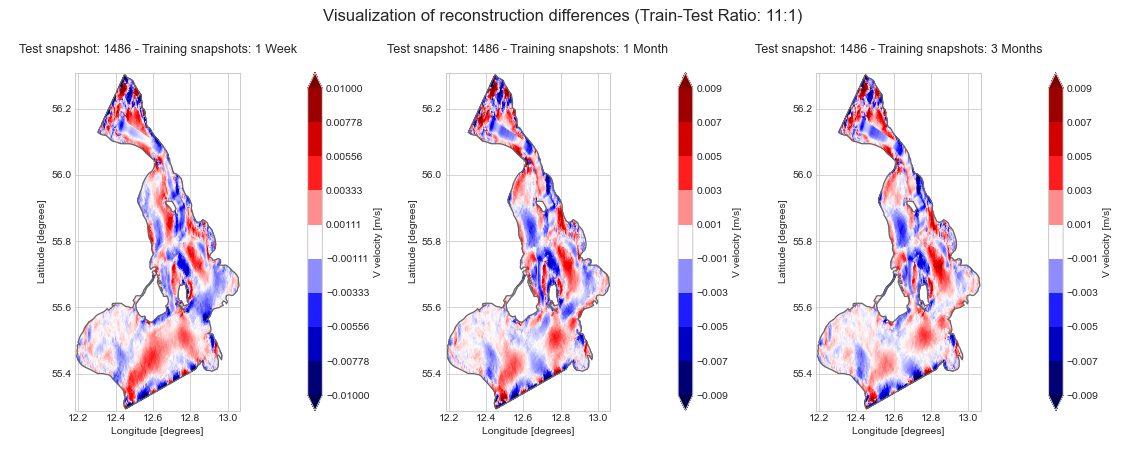

In [19]:
# Create subplot (1 by 3):
fig, axs = plt.subplots(1, 3, figsize=(15,6))

labels = ["1 Week", "1 Month", "3 Months"]

# Loop slices to test:
for i, test_slice in enumerate([v_test.shape[0]-1]):

    # Loop over time-scales:
    for j, scale in enumerate([2,5,8]):

        v_slice = v_test[test_slice].reshape(1, -1)
        v_slice_recon = reconstruct(v_slice, scalers[scale], pcas[scale])

        plot_obj.values = (v_slice - v_slice_recon).reshape(-1)

        cmap_max = np.quantile(np.abs(plot_obj.values), 0.99)
        digits = np.sum([cmap_max * (10**i) < 1 for i in range(5)])
        cmap_max = np.round(cmap_max, digits)

        plot_obj.plot(ax=axs[j], cmap="seismic",
                      title=f"\nTest snapshot: {test_slice} - Training snapshots: {labels[j]}\n",
                      vmin=-cmap_max, vmax=cmap_max)


fig.suptitle("Visualization of reconstruction differences (Train-Test Ratio: 11:1)", fontsize=16)

plt.tight_layout()
plt.show()

In [20]:
# Save figure:
fig.savefig("../Figures/Exp_10_recon_diffs1.png", dpi=100)

## Data split: (6 months training data. 6 month test data.)

In [21]:
# Split data into training and test sets:
v_train2 = data.V_velocity.sel(time=slice("1997-01-01 00:00:00",
                                          "1997-07-01 00:00:00")).values

v_test2 = data.V_velocity.sel(time=slice("1997-07-01 00:00:00",
                                         "1998-01-01 00:00:00")).values

### Samples:

In [22]:
# First week, week-sized random sample, and week-sized systematic sample:
wk_1 = range(0, 48*7); np.random.seed(42)
wk_random = np.random.choice(range(0, v_train2.shape[0]), 48*7, replace=False)
wk_system = np.linspace(0, v_train2.shape[0]-1, 48*7, dtype=int)

# First month, month-sized random sample, and month-sized systematic sample:
mth_1 = range(0, 48*7*4)
mth_random = np.random.choice(range(0, v_train2.shape[0]), 48*7*4, replace=False)
mth_system = np.linspace(0, v_train2.shape[0]-1, 48*7*4, dtype=int)

# First three months, three-month-sized random sample, and three-month-sized systematic sample:
mth_3 = range(0, 48*7*4*3)
mth_3_random = np.random.choice(range(0, v_train2.shape[0]), 48*7*4*3, replace=False)
mth_3_system = np.linspace(0, v_train2.shape[0]-1, 48*7*4*3, dtype=int)


In [23]:
# Sample indices:
sample_ids = [wk_1, wk_random, wk_system,
              mth_1, mth_random, mth_system,
              mth_3, mth_3_random, mth_3_system]

### Results

In [24]:
# Auxilliary variable:
compute = 1

# Try to load results from earlier runs:
if 1:

    # Load scalers and pcas if they exist:
    if os.path.exists("../Data_Results/Exp_10_scalers2.pkl") and \
        os.path.exists("../Data_Results/Exp_10_pcas2.pkl"):
        
        # Load scalers:
        with open("../Data_Results/Exp_10_scalers2.pkl", "rb") as f:
            scalers2 = pkl.load(f)

        # Load pcas:
        with open("../Data_Results/Exp_10_pcas2.pkl", "rb") as f:
            pcas2 = pkl.load(f)

        # Set compute to 0:
        compute = 0

print(f"compute = {compute}")

compute = 0


In [25]:
# Compute scalers and pcas (+4 min):
if compute:

    # Lists for scalers and pcas:
    scalers2 = [];  pcas2 = []

    for i in range(len(sample_ids)):
        
        print(f"Sample {i+1} of {len(sample_ids)}", end="\r")

        # Pick data:
        v_data = v_train2[sample_ids[i]]

        # Create scaler:
        scaler = StandardScaler()

        # Fit scaler:
        scaler.fit(v_data)

        # Scale data:
        v_data_scaled = scaler.transform(v_data)

        # Create pca:
        pca = myModels.IPCA(n_components=100)

        # Fit pca:
        pca.fit(v_data_scaled)

        # Append scalers and pcas:
        scalers2.append(scaler)
        pcas2.append(pca)

In [26]:
# Save scalers and pcas (in Coding/Data_Results):
if compute:
    with open("../Data_Results/Exp_10_scalers2.pkl", "wb") as f:
        pkl.dump(scalers2, f)

    with open("../Data_Results/Exp_10_pcas2.pkl", "wb") as f:
        pkl.dump(pcas2, f)

In [27]:
def reconstruct(data, scaler, pca, batch_size=1000):
    """
    Reconstructs data using scaler and pca.
    """

    if data.shape[0] < batch_size:
        data_scaled = scaler.transform(data)
        data_scaled_recon = pca.predict(data_scaled)
        data_recon = scaler.inverse_transform(data_scaled_recon)

    else:
        data_recon = np.zeros(data.shape)
        for i in range(0, data.shape[0], batch_size)[:-1]:

            data_scaled = scaler.transform(data[i:i+batch_size])
            data_scaled_recon = pca.predict(data_scaled)
            
            data_recon[i:i+batch_size] = \
                scaler.inverse_transform(data_scaled_recon)

        data_scaled = scaler.transform(data[i+batch_size:])
        data_scaled_recon = pca.predict(data_scaled)
        data_recon[i+batch_size:] = scaler.inverse_transform(data_scaled_recon)

    return data_recon

In [28]:
# Auxilliary variable:
compute = 1

# Try to load results from earlier runs:
if 1:

    # Load results if they exist:
    if os.path.exists("../Data_Results/Exp_10_recon_errors2.pkl"):

        # Load results:
        with open("../Data_Results/Exp_10_recon_errors2.pkl", "rb") as f:
            recon_errors2 = pkl.load(f)
        
        # Extract results:
        fit_recon_errors2, train_recon_errors2, test_recon_errors2 = \
            recon_errors2

        # Set compute to 0:
        compute = 0

print(f"compute = {compute}")

compute = 0


In [29]:
# Only used for computing reconstruction errors: (~ 4 min)
if compute:

    # Allocate lists:
    fit_recon_errors2 = []; train_recon_errors2 = []; test_recon_errors2 = []

    # Compute reconstruction errors:
    for i in range(len(sample_ids)):
        
        print(f"Reconstructing sample {i+1} of {len(sample_ids)}", end="\r")

        # Fitting data:
        v_fit = v_train2[sample_ids[i]]
        
        # Loop over data:
        for j, v_data in enumerate([v_fit, v_train2, v_test2]):

            # Reconstruct data:
            v_data_recon = reconstruct(v_data, scalers2[i], pcas2[i])

            # Compute reconstruction errors:
            recon_error = mf.rmse(v_data, v_data_recon, axis=1).mean()

            # Append reconstruction errors:
            if j == 0:
                fit_recon_errors2.append(recon_error)
            elif j == 1:
                train_recon_errors2.append(recon_error)
            else:
                test_recon_errors2.append(recon_error)
            

In [30]:
# Save results (in Coding/Data_Results):
if compute:

    # Combine errors:
    recon_errors2 = \
        [fit_recon_errors2, train_recon_errors2, test_recon_errors2]

    # Save results:
    with open("../Data_Results/Exp_10_recon_errors2.pkl", "wb") as f:
        pkl.dump(recon_errors2, f)

In [31]:
# Create dataframe with average RMSEs:
df2 = pd.DataFrame({
    "PCA": ["First week", "Week-sized random sample", 
            "Week-sized systematic sample",
            "First month", "Month-sized random sample", 
            "Month-sized systematic sample",
            "First three months", "Three-month-sized random sample",
            "Three-month-sized systematic sample",],
    "Fit RMSE": fit_recon_errors2,
    "Train RMSE": train_recon_errors2,
    "Test RMSE": test_recon_errors2})


In [32]:
# Copy to Powerpoint:
df2.round(6)

,PCA,Fit RMSE,Train RMSE,Test RMSE
0,First week,0.000319,0.012016,0.011473
1,Week-sized random sample,0.002292,0.003637,0.004223
2,Week-sized systematic sample,0.002496,0.003504,0.004078
3,First month,0.001573,0.005398,0.005554
4,Month-sized random sample,0.002905,0.003174,0.003798
5,Month-sized systematic sample,0.003019,0.003089,0.003693
6,First three months,0.002801,0.003483,0.004064
7,Three-month-sized random sample,0.002992,0.003060,0.003684
8,Three-month-sized systematic sample,0.003027,0.003035,0.003672


### Visualizations

In [33]:
plot_obj = data.V_velocity[0].copy()

<IPython.core.display.Javascript object>


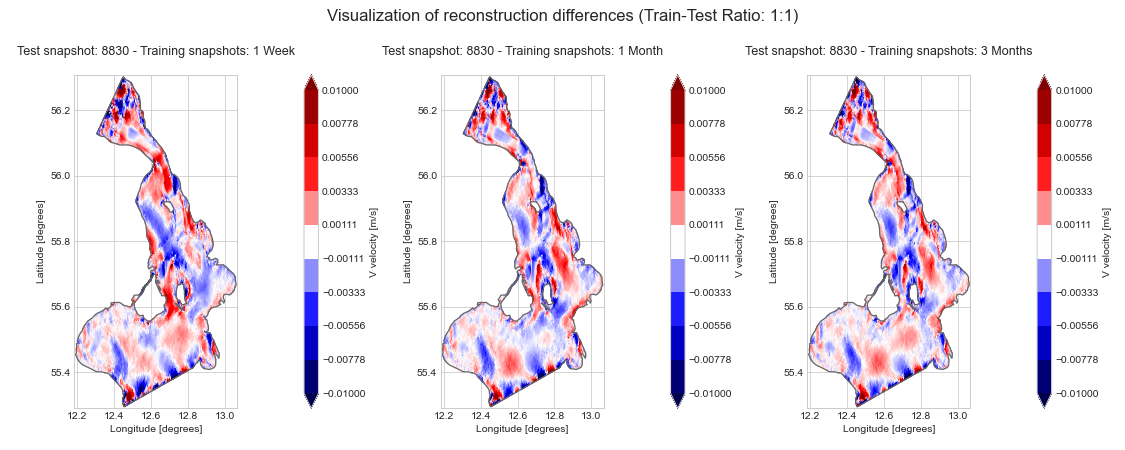

In [34]:
# Create subplot (1 by 3):
fig2, axs2 = plt.subplots(1, 3, figsize=(15,6))

labels = ["1 Week", "1 Month", "3 Months"]

# Loop slices to test:
for i, test_slice in enumerate([v_test2.shape[0]-1]):

    # Loop over time-scales:
    for j, scale in enumerate([2,5,8]):

        v_slice = v_test2[test_slice].reshape(1, -1)
        v_slice_recon = reconstruct(v_slice, scalers2[scale], pcas2[scale])

        plot_obj.values = (v_slice - v_slice_recon).reshape(-1)

        cmap_max = np.quantile(np.abs(plot_obj.values), 0.99)
        digits = np.sum([cmap_max * (10**i) < 1 for i in range(5)])
        cmap_max = np.round(cmap_max, digits)

        plot_obj.plot(ax=axs2[j], cmap="seismic",
                      title=f"\nTest snapshot: {test_slice} - Training snapshots: {labels[j]}\n",
                      vmin=-cmap_max, vmax=cmap_max)


fig2.suptitle("Visualization of reconstruction differences (Train-Test Ratio: 1:1)", fontsize=16)

plt.tight_layout()
plt.show()

In [35]:
# Save figure:
fig2.savefig("../Figures/Exp_10_recon_diffs2.png", dpi=100)

## Extras

### Plot of principal components

In [36]:
# Choose whether to re-visualize individual PCs:
if 0:

    # Define principal component ids:
    pcs = range(100)

    # Define plot object:
    plot_obj = data.V_velocity[0].copy()

    # Extract principal components:
    princomps = np.array(pcas2[-1].model.components_)

    # Loop over pcs: (~ 9 min)
    for pc in pcs:

        fig3 = plt.figure(num=0, figsize=(6,4.8), dpi=100)
        axs3 = fig3.add_subplot(111)

        # Print status:
        print(f"Visualizing principal component {pc+1} of {len(pcs)}")

        # Set plot object values:
        plot_obj.values = princomps[pc]

        # Maximum value:
        cmap_max = np.quantile(np.abs(plot_obj.values), 0.99)
        digits = np.sum([cmap_max * (10**i) < 1 for i in range(5)])
        cmap_max = np.round(cmap_max, digits)

        # Plot:
        plot_obj.plot(ax=axs3,
                      title=f"Principal Component {pc+1}", cmap="seismic",
        vmin=-cmap_max, vmax=cmap_max)


        # Save figure:
        fig3.savefig(f"../Figures/Exp_10_pcs/Exp_10_pc{pc+1}.png")

        plt.close(fig3)


### Combining images into grids

In [37]:
# Set the dimensions of the grid
columns = 5
rows = 4

# Set the dimensions of each image
width = 600
height = 480

# Create a new image to hold the grid
grid = Image.new('RGB', (columns*width, rows*height))

# Loop over 5 images:
for k in range(5):

    # Set count:
    count = k*20

    # Loop through each image and paste it onto the grid
    for j in range(rows):
        for i in range(columns):

            count += 1

            # Open the image
            image_path = f"../Figures/Exp_10_pcs/Exp_10_pc{count}.png"
            image = Image.open(image_path)
            
            # Calculate the position to paste the image
            x = i * width
            y = j * height
            
            # Paste the image onto the grid
            grid.paste(image, (x, y))

    # Save the grid image
    grid.save(f'../Figures/Exp_10_{k*20+1}-{(k+1)*20}pc.png')